# Preppin' Data Challenge -
## 2023: Week 32 - HR Month - Reshaping Generations
## Created by: Ghafar Shah

### Challenge: https://preppindata.blogspot.com/2023/08/2023-week-32-hr-month-reshaping.html

Now that all of the missing IDs have been filled in from Week 31 exercise, HR would like us to add several age groupings to the dataset for reporting, so the employee’s exact date of birth can be removed from the dataset. Pew definitions was used each generation.

### Import required packages for data analysis

In [1]:
import pandas as pd
import numpy as np

### Import generations table based on Pew definitions

In [2]:
# read in generations info
generations = pd.read_csv('generations.csv')

# preview dataframe
generations

,generation,start_year,end_year,source
0,Greatest Generation,NaN,1927.0,https://www.pewtrusts.org/en/research-and-anal...
1,Silent Generation,1928.0,1945.0,https://www.pewtrusts.org/en/research-and-anal...
2,Baby Boomers,1946.0,1964.0,https://www.pewtrusts.org/en/research-and-anal...
3,Generation X,1965.0,1980.0,https://www.pewtrusts.org/en/research-and-anal...
4,Millenials,1981.0,1996.0,https://www.pewtrusts.org/en/research-and-anal...
5,Generation Z,1997.0,2012.0,https://www.pewtrusts.org/en/research-and-anal...
6,Generation Alpha,2013.0,NaN,No official consensus on when Gen Alpha begins...


### Convert start_year and end_year columns in generations table to whole numbers

In [3]:
# Replace any NaNs with zeros so the conversion to numeric works 
generations['start_year'] = generations['start_year'].fillna(0).astype(int)
generations['end_year'] = generations['end_year'].fillna(0).astype(int)

#preview dataframe
generations

,generation,start_year,end_year,source
0,Greatest Generation,0,1927,https://www.pewtrusts.org/en/research-and-anal...
1,Silent Generation,1928,1945,https://www.pewtrusts.org/en/research-and-anal...
2,Baby Boomers,1946,1964,https://www.pewtrusts.org/en/research-and-anal...
3,Generation X,1965,1980,https://www.pewtrusts.org/en/research-and-anal...
4,Millenials,1981,1996,https://www.pewtrusts.org/en/research-and-anal...
5,Generation Z,1997,2012,https://www.pewtrusts.org/en/research-and-anal...
6,Generation Alpha,2013,0,No official consensus on when Gen Alpha begins...


### Import the ee_monthly file (ee_monthly)

In [4]:
ee_monthly_roster = pd.read_csv('Final_Monthly_EE_Roster.csv')
ee_monthly_roster

,Unnamed: 0,dc_nbr,month_end_date,employee_id,guid,hire_date,leave_date
0,0,1,30/04/2018,E00555,3ffe5abe-8b42-4c82-8464-ed8159f68dcc,22/04/2018,NaN
1,1,1,30/04/2018,E00143,e062c7aa-159e-4caa-be7e-e63b283ad489,24/04/2018,NaN
2,2,1,30/04/2018,E01024,a129f770-ea7e-47aa-b561-818a9331883b,26/04/2018,NaN
3,3,1,30/04/2018,E00939,f799ab3c-7b3b-458f-bc62-d24f4269b967,13/04/2018,NaN
4,4,1,30/04/2018,E00535,6f1e1bfe-0d58-4809-8410-bb8de79335e5,30/04/2018,NaN
...,...,...,...,...,...,...,...
7435,7435,6,31/12/2020,E01397,42ce428f-3c99-424b-98d2-ec4896e94d3a,11/11/2019,NaN
7436,7436,6,30/11/2021,E01397,42ce428f-3c99-424b-98d2-ec4896e94d3a,11/11/2019,NaN
7437,7437,6,31/12/2021,E01397,42ce428f-3c99-424b-98d2-ec4896e94d3a,11/11/2019,NaN
7438,7438,6,30/11/2022,E01397,42ce428f-3c99-424b-98d2-ec4896e94d3a,11/11/2019,NaN


### Import the employee demographics file (ee_dim)

In [5]:
ee_dim = pd.read_csv('Final_Employee_Dimensions_Roster.csv')
ee_dim

,Unnamed: 0,employee_id,guid,first_name,last_name,date_of_birth,nationality,gender,email,hire_date,leave_date
0,0,E00001,44eca9c9-0081-4d69-906e-73285b7f6dd2,Terry,Cooper,17/05/1999,US,male,terry.cooper@example.com,07/09/2022,30/08/2022
1,1,E00003,16d3207c-8a95-4abb-9d6b-46215ab73d83,William,Phillips,14/08/1998,GB,male,william.phillips@example.com,20/03/2023,20/06/2023
2,2,E00006,afededdb-6441-423b-9917-872e22597dd5,Patsy,Davis,06/11/2000,US,female,patsy.davis@example.com,04/09/2022,10/06/2023
3,3,E00007,a55792b2-b0ac-464e-bcd9-68865662156b,Florence,Hart,03/12/2000,GB,female,florence.hart@example.com,22/04/2022,NaN
4,4,E00009,3af26094-7a1a-4bd9-ad56-a158670fb732,Jayden,Wells,16/10/2000,US,male,jayden.wells@example.com,17/03/2023,NaN
...,...,...,...,...,...,...,...,...,...,...,...
532,532,E01511,59ce341d-ca3e-43a3-aead-76f137c968f3,Stanley,Montgomery,16/06/1956,GB,male,stanley.montgomery@example.com,27/03/2022,21/01/2023
533,533,E01514,8a3ad32b-ad80-4b33-b246-4396d9eeffb0,Melvin,Williams,28/12/1947,GB,male,melvin.williams@example.com,03/03/2023,NaN
534,534,E01522,fa3d652f-b03e-40c6-a43a-cf8cc16e5867,Heather,Morgan,26/10/1946,GB,female,heather.morgan@example.com,03/12/2022,16/01/2023
535,535,E01523,22e7b134-44d5-480f-81de-77acd5a9a4d5,Darrell,Little,10/12/1946,GB,male,darrell.little@example.com,28/02/2019,18/06/2020


### Add a new column, generation_name, which includes the generation name (e.g., Generation X (1965-1980))
- If the generation doesn’t have a start year, the text should be “(born in or before End Year)”
- If the generation doesn’t have an end year, the text should be “(born in or after Start Year)”

In [6]:
"""

Using .apply() to iterate over each row of the DataFrame and apply the lambda function to it
And, the lambda function takes a single argument, called "row", which is a record from the DataFrame
    
"""

 # Check if there are any values equal to 0 in the 'start_year' column of the 'generations' DataFrame.
if (generations['start_year'] == 0).any():
    
    generations['generations'] = generations.apply(lambda row: 
    'born in or before ' + str(row['end_year']) if row['start_year'] == 0 else 
    str(row['generation']) + ' (' + str(row['start_year']) + '-' + str(row['end_year']) + ')', axis=1)

 # Check if there are any values equal to 0 in the 'end_year' column of the 'generations' DataFrame.
if (generations['end_year'] == 0).any():
    
    generations.loc[generations['end_year'].isna(), 'generations'] = generations.apply(lambda row: 
    'born in or after ' + str(row['start_year']) if row['end_year'] == 0 else 
    str(row['generation']) + ' (' + str(row['start_year']) + '-' + str(row['end_year']) + ')', axis=1)

In [7]:
# Preview updated generations DataFrame
generations.head()

,generation,start_year,end_year,source,generations
0,Greatest Generation,0,1927,https://www.pewtrusts.org/en/research-and-anal...,born in or before 1927
1,Silent Generation,1928,1945,https://www.pewtrusts.org/en/research-and-anal...,Silent Generation (1928-1945)
2,Baby Boomers,1946,1964,https://www.pewtrusts.org/en/research-and-anal...,Baby Boomers (1946-1964)
3,Generation X,1965,1980,https://www.pewtrusts.org/en/research-and-anal...,Generation X (1965-1980)
4,Millenials,1981,1996,https://www.pewtrusts.org/en/research-and-anal...,Millenials (1981-1996)


### Calculate the employee’s birth year from the date_of_birth

In [8]:
# Preserve the year after last slash "/"
ee_dim = ee_dim.assign(Years=ee_dim.date_of_birth.str[-4:])

# Create a Birth_Year numeric column and convert to whole number (remove decimal)
ee_dim['Birth_Year'] = pd.to_numeric(ee_dim['Years'], errors='coerce').fillna(0).astype(int)

ee_dim

,Unnamed: 0,employee_id,guid,first_name,last_name,date_of_birth,nationality,gender,email,hire_date,leave_date,Years,Birth_Year
0,0,E00001,44eca9c9-0081-4d69-906e-73285b7f6dd2,Terry,Cooper,17/05/1999,US,male,terry.cooper@example.com,07/09/2022,30/08/2022,1999,1999
1,1,E00003,16d3207c-8a95-4abb-9d6b-46215ab73d83,William,Phillips,14/08/1998,GB,male,william.phillips@example.com,20/03/2023,20/06/2023,1998,1998
2,2,E00006,afededdb-6441-423b-9917-872e22597dd5,Patsy,Davis,06/11/2000,US,female,patsy.davis@example.com,04/09/2022,10/06/2023,2000,2000
3,3,E00007,a55792b2-b0ac-464e-bcd9-68865662156b,Florence,Hart,03/12/2000,GB,female,florence.hart@example.com,22/04/2022,NaN,2000,2000
4,4,E00009,3af26094-7a1a-4bd9-ad56-a158670fb732,Jayden,Wells,16/10/2000,US,male,jayden.wells@example.com,17/03/2023,NaN,2000,2000
...,...,...,...,...,...,...,...,...,...,...,...,...,...
532,532,E01511,59ce341d-ca3e-43a3-aead-76f137c968f3,Stanley,Montgomery,16/06/1956,GB,male,stanley.montgomery@example.com,27/03/2022,21/01/2023,1956,1956
533,533,E01514,8a3ad32b-ad80-4b33-b246-4396d9eeffb0,Melvin,Williams,28/12/1947,GB,male,melvin.williams@example.com,03/03/2023,NaN,1947,1947
534,534,E01522,fa3d652f-b03e-40c6-a43a-cf8cc16e5867,Heather,Morgan,26/10/1946,GB,female,heather.morgan@example.com,03/12/2022,16/01/2023,1946,1946
535,535,E01523,22e7b134-44d5-480f-81de-77acd5a9a4d5,Darrell,Little,10/12/1946,GB,male,darrell.little@example.com,28/02/2019,18/06/2020,1946,1946


### Check how many Birth Years have value of 0 
Remember, we originally changed the NaN (isna) to replace it with zero instead due to whole number conversion

In [9]:
# Checks number of 0s in birth year column from ee_dim table
num_zeros = (ee_dim['Birth_Year'] == 0).sum()
num_zeros

3

In [10]:
# Check ee_dim table data types
ee_dim.dtypes

Unnamed: 0        int64
employee_id      object
guid             object
first_name       object
last_name        object
date_of_birth    object
nationality      object
gender           object
email            object
hire_date        object
leave_date       object
Years            object
Birth_Year        int64
dtype: object

In [11]:
# Check generations table data types
generations.dtypes

generation     object
start_year      int64
end_year        int64
source         object
generations    object
dtype: object

###  Finds the generation label based on Birth_Year in employee demographics table

In [12]:
# The find_generation function finds the generation label based on Birth_Year
def find_generation(birth_year):
    
    # Iterating through each row
    for index, row in generations.iterrows():
        
        # Check if the birth year falls within the start_year and end_year range
        if row['start_year'] <= birth_year <= row['end_year']:
            
            # If it does, then lets return the corresponding generation name
            return row['generations']
    
    # If no matching generation name is found, then return Not Provided
    return 'Not Provided'

In [13]:
# Apply the find_generation function to each row in ee_dim DataFrame
ee_dim['generation_name'] = ee_dim['Birth_Year'].apply(find_generation)

# Preview updated ee_dim DataFrame
ee_dim

,Unnamed: 0,employee_id,guid,first_name,last_name,date_of_birth,nationality,gender,email,hire_date,leave_date,Years,Birth_Year,generation_name
0,0,E00001,44eca9c9-0081-4d69-906e-73285b7f6dd2,Terry,Cooper,17/05/1999,US,male,terry.cooper@example.com,07/09/2022,30/08/2022,1999,1999,Generation Z (1997-2012)
1,1,E00003,16d3207c-8a95-4abb-9d6b-46215ab73d83,William,Phillips,14/08/1998,GB,male,william.phillips@example.com,20/03/2023,20/06/2023,1998,1998,Generation Z (1997-2012)
2,2,E00006,afededdb-6441-423b-9917-872e22597dd5,Patsy,Davis,06/11/2000,US,female,patsy.davis@example.com,04/09/2022,10/06/2023,2000,2000,Generation Z (1997-2012)
3,3,E00007,a55792b2-b0ac-464e-bcd9-68865662156b,Florence,Hart,03/12/2000,GB,female,florence.hart@example.com,22/04/2022,NaN,2000,2000,Generation Z (1997-2012)
4,4,E00009,3af26094-7a1a-4bd9-ad56-a158670fb732,Jayden,Wells,16/10/2000,US,male,jayden.wells@example.com,17/03/2023,NaN,2000,2000,Generation Z (1997-2012)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
532,532,E01511,59ce341d-ca3e-43a3-aead-76f137c968f3,Stanley,Montgomery,16/06/1956,GB,male,stanley.montgomery@example.com,27/03/2022,21/01/2023,1956,1956,Baby Boomers (1946-1964)
533,533,E01514,8a3ad32b-ad80-4b33-b246-4396d9eeffb0,Melvin,Williams,28/12/1947,GB,male,melvin.williams@example.com,03/03/2023,NaN,1947,1947,Baby Boomers (1946-1964)
534,534,E01522,fa3d652f-b03e-40c6-a43a-cf8cc16e5867,Heather,Morgan,26/10/1946,GB,female,heather.morgan@example.com,03/12/2022,16/01/2023,1946,1946,Baby Boomers (1946-1964)
535,535,E01523,22e7b134-44d5-480f-81de-77acd5a9a4d5,Darrell,Little,10/12/1946,GB,male,darrell.little@example.com,28/02/2019,18/06/2020,1946,1946,Baby Boomers (1946-1964)


In [14]:
# Check the ee_dim table record count
ee_dim.count()

Unnamed: 0         537
employee_id        537
guid               537
first_name         537
last_name          537
date_of_birth      534
nationality        537
gender             537
email              537
hire_date          537
leave_date         291
Years              534
Birth_Year         537
generation_name    537
dtype: int64

### Join the monthly roster to the employee demographics data (ee_dim) on employee_id

In [15]:
# Join monthly employee table to ee_dim table on column employee_id
monthly_ee_df = ee_monthly_roster.merge(ee_dim , on='employee_id',how='left')

In [16]:
# Preview monthly_ee_df dataframe
monthly_ee_df

,Unnamed: 0_x,dc_nbr,month_end_date,employee_id,guid_x,hire_date_x,leave_date_x,Unnamed: 0_y,guid_y,first_name,last_name,date_of_birth,nationality,gender,email,hire_date_y,leave_date_y,Years,Birth_Year,generation_name
0,0,1,30/04/2018,E00555,3ffe5abe-8b42-4c82-8464-ed8159f68dcc,22/04/2018,NaN,184,3ffe5abe-8b42-4c82-8464-ed8159f68dcc,Jenny,Mccoy,16/07/1995,GB,female,jenny.mccoy@example.com,22/04/2018,13/02/2020,1995,1995,Millenials (1981-1996)
1,1,1,30/04/2018,E00143,e062c7aa-159e-4caa-be7e-e63b283ad489,24/04/2018,NaN,47,e062c7aa-159e-4caa-be7e-e63b283ad489,Anna,Ross,16/03/1999,US,female,anna.ross@example.com,24/04/2018,NaN,1999,1999,Generation Z (1997-2012)
2,2,1,30/04/2018,E01024,a129f770-ea7e-47aa-b561-818a9331883b,26/04/2018,NaN,359,a129f770-ea7e-47aa-b561-818a9331883b,Lance,Alvarez,14/08/1974,US,male,lance.alvarez@example.com,26/04/2018,NaN,1974,1974,Generation X (1965-1980)
3,3,1,30/04/2018,E00939,f799ab3c-7b3b-458f-bc62-d24f4269b967,13/04/2018,NaN,328,f799ab3c-7b3b-458f-bc62-d24f4269b967,Jordan,Tucker,15/03/1972,GB,male,jordan.tucker@example.com,28/10/2019,25/01/2019,1972,1972,Generation X (1965-1980)
4,4,1,30/04/2018,E00535,6f1e1bfe-0d58-4809-8410-bb8de79335e5,30/04/2018,NaN,177,6f1e1bfe-0d58-4809-8410-bb8de79335e5,Terrance,Freeman,17/05/1990,US,male,terrance.freeman@example.com,30/04/2018,08/11/2018,1990,1990,Millenials (1981-1996)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7435,7435,6,31/12/2020,E01397,42ce428f-3c99-424b-98d2-ec4896e94d3a,11/11/2019,NaN,491,42ce428f-3c99-424b-98d2-ec4896e94d3a,Kazutaka,Ozaki,25/04/1957,GB,male,Kazutaka.Ozaki@example.com,11/11/2019,NaN,1957,1957,Baby Boomers (1946-1964)
7436,7436,6,30/11/2021,E01397,42ce428f-3c99-424b-98d2-ec4896e94d3a,11/11/2019,NaN,491,42ce428f-3c99-424b-98d2-ec4896e94d3a,Kazutaka,Ozaki,25/04/1957,GB,male,Kazutaka.Ozaki@example.com,11/11/2019,NaN,1957,1957,Baby Boomers (1946-1964)
7437,7437,6,31/12/2021,E01397,42ce428f-3c99-424b-98d2-ec4896e94d3a,11/11/2019,NaN,491,42ce428f-3c99-424b-98d2-ec4896e94d3a,Kazutaka,Ozaki,25/04/1957,GB,male,Kazutaka.Ozaki@example.com,11/11/2019,NaN,1957,1957,Baby Boomers (1946-1964)
7438,7438,6,30/11/2022,E01397,42ce428f-3c99-424b-98d2-ec4896e94d3a,11/11/2019,NaN,491,42ce428f-3c99-424b-98d2-ec4896e94d3a,Kazutaka,Ozaki,25/04/1957,GB,male,Kazutaka.Ozaki@example.com,11/11/2019,NaN,1957,1957,Baby Boomers (1946-1964)


In [17]:
# Check datatype in monthly_ee_df dataframe
monthly_ee_df.dtypes

Unnamed: 0_x        int64
dc_nbr              int64
month_end_date     object
employee_id        object
guid_x             object
hire_date_x        object
leave_date_x       object
Unnamed: 0_y        int64
guid_y             object
first_name         object
last_name          object
date_of_birth      object
nationality        object
gender             object
email              object
hire_date_y        object
leave_date_y       object
Years              object
Birth_Year          int64
generation_name    object
dtype: object

### Format the dates so that we can use it later to calculate an employee’s age (in full years)
We need to formate the dates in the monthly_ee_df dataframe to date datatype

In [18]:
# Convert the date_string column to datetime format
monthly_ee_df['Date_Of_Birth'] = pd.to_datetime(monthly_ee_df['date_of_birth'], format='%d/%m/%Y')
monthly_ee_df['Month_End_Date'] = pd.to_datetime(monthly_ee_df['month_end_date'], format='%d/%m/%Y')

In [19]:
#Preview the table
monthly_ee_df

,Unnamed: 0_x,dc_nbr,month_end_date,employee_id,guid_x,hire_date_x,leave_date_x,Unnamed: 0_y,guid_y,first_name,...,nationality,gender,email,hire_date_y,leave_date_y,Years,Birth_Year,generation_name,Date_Of_Birth,Month_End_Date
0,0,1,30/04/2018,E00555,3ffe5abe-8b42-4c82-8464-ed8159f68dcc,22/04/2018,NaN,184,3ffe5abe-8b42-4c82-8464-ed8159f68dcc,Jenny,...,GB,female,jenny.mccoy@example.com,22/04/2018,13/02/2020,1995,1995,Millenials (1981-1996),1995-07-16,2018-04-30
1,1,1,30/04/2018,E00143,e062c7aa-159e-4caa-be7e-e63b283ad489,24/04/2018,NaN,47,e062c7aa-159e-4caa-be7e-e63b283ad489,Anna,...,US,female,anna.ross@example.com,24/04/2018,NaN,1999,1999,Generation Z (1997-2012),1999-03-16,2018-04-30
2,2,1,30/04/2018,E01024,a129f770-ea7e-47aa-b561-818a9331883b,26/04/2018,NaN,359,a129f770-ea7e-47aa-b561-818a9331883b,Lance,...,US,male,lance.alvarez@example.com,26/04/2018,NaN,1974,1974,Generation X (1965-1980),1974-08-14,2018-04-30
3,3,1,30/04/2018,E00939,f799ab3c-7b3b-458f-bc62-d24f4269b967,13/04/2018,NaN,328,f799ab3c-7b3b-458f-bc62-d24f4269b967,Jordan,...,GB,male,jordan.tucker@example.com,28/10/2019,25/01/2019,1972,1972,Generation X (1965-1980),1972-03-15,2018-04-30
4,4,1,30/04/2018,E00535,6f1e1bfe-0d58-4809-8410-bb8de79335e5,30/04/2018,NaN,177,6f1e1bfe-0d58-4809-8410-bb8de79335e5,Terrance,...,US,male,terrance.freeman@example.com,30/04/2018,08/11/2018,1990,1990,Millenials (1981-1996),1990-05-17,2018-04-30
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7435,7435,6,31/12/2020,E01397,42ce428f-3c99-424b-98d2-ec4896e94d3a,11/11/2019,NaN,491,42ce428f-3c99-424b-98d2-ec4896e94d3a,Kazutaka,...,GB,male,Kazutaka.Ozaki@example.com,11/11/2019,NaN,1957,1957,Baby Boomers (1946-1964),1957-04-25,2020-12-31
7436,7436,6,30/11/2021,E01397,42ce428f-3c99-424b-98d2-ec4896e94d3a,11/11/2019,NaN,491,42ce428f-3c99-424b-98d2-ec4896e94d3a,Kazutaka,...,GB,male,Kazutaka.Ozaki@example.com,11/11/2019,NaN,1957,1957,Baby Boomers (1946-1964),1957-04-25,2021-11-30
7437,7437,6,31/12/2021,E01397,42ce428f-3c99-424b-98d2-ec4896e94d3a,11/11/2019,NaN,491,42ce428f-3c99-424b-98d2-ec4896e94d3a,Kazutaka,...,GB,male,Kazutaka.Ozaki@example.com,11/11/2019,NaN,1957,1957,Baby Boomers (1946-1964),1957-04-25,2021-12-31
7438,7438,6,30/11/2022,E01397,42ce428f-3c99-424b-98d2-ec4896e94d3a,11/11/2019,NaN,491,42ce428f-3c99-424b-98d2-ec4896e94d3a,Kazutaka,...,GB,male,Kazutaka.Ozaki@example.com,11/11/2019,NaN,1957,1957,Baby Boomers (1946-1964),1957-04-25,2022-11-30


### Calculate the employee’s age (in full years) as of the month_end_date
Now, we're calculating the employee's age (in full years) after converting the dates format to date datatype

In [20]:
# Calculate full year age based on month_end_date
age_in_years = ((monthly_ee_df['Month_End_Date'] - monthly_ee_df['Date_Of_Birth']).dt.days / 365)
monthly_ee_df['age'] = age_in_years.fillna(0).astype(int)

In [21]:
# Preview DataFrame
monthly_ee_df

,Unnamed: 0_x,dc_nbr,month_end_date,employee_id,guid_x,hire_date_x,leave_date_x,Unnamed: 0_y,guid_y,first_name,...,gender,email,hire_date_y,leave_date_y,Years,Birth_Year,generation_name,Date_Of_Birth,Month_End_Date,age
0,0,1,30/04/2018,E00555,3ffe5abe-8b42-4c82-8464-ed8159f68dcc,22/04/2018,NaN,184,3ffe5abe-8b42-4c82-8464-ed8159f68dcc,Jenny,...,female,jenny.mccoy@example.com,22/04/2018,13/02/2020,1995,1995,Millenials (1981-1996),1995-07-16,2018-04-30,22
1,1,1,30/04/2018,E00143,e062c7aa-159e-4caa-be7e-e63b283ad489,24/04/2018,NaN,47,e062c7aa-159e-4caa-be7e-e63b283ad489,Anna,...,female,anna.ross@example.com,24/04/2018,NaN,1999,1999,Generation Z (1997-2012),1999-03-16,2018-04-30,19
2,2,1,30/04/2018,E01024,a129f770-ea7e-47aa-b561-818a9331883b,26/04/2018,NaN,359,a129f770-ea7e-47aa-b561-818a9331883b,Lance,...,male,lance.alvarez@example.com,26/04/2018,NaN,1974,1974,Generation X (1965-1980),1974-08-14,2018-04-30,43
3,3,1,30/04/2018,E00939,f799ab3c-7b3b-458f-bc62-d24f4269b967,13/04/2018,NaN,328,f799ab3c-7b3b-458f-bc62-d24f4269b967,Jordan,...,male,jordan.tucker@example.com,28/10/2019,25/01/2019,1972,1972,Generation X (1965-1980),1972-03-15,2018-04-30,46
4,4,1,30/04/2018,E00535,6f1e1bfe-0d58-4809-8410-bb8de79335e5,30/04/2018,NaN,177,6f1e1bfe-0d58-4809-8410-bb8de79335e5,Terrance,...,male,terrance.freeman@example.com,30/04/2018,08/11/2018,1990,1990,Millenials (1981-1996),1990-05-17,2018-04-30,27
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7435,7435,6,31/12/2020,E01397,42ce428f-3c99-424b-98d2-ec4896e94d3a,11/11/2019,NaN,491,42ce428f-3c99-424b-98d2-ec4896e94d3a,Kazutaka,...,male,Kazutaka.Ozaki@example.com,11/11/2019,NaN,1957,1957,Baby Boomers (1946-1964),1957-04-25,2020-12-31,63
7436,7436,6,30/11/2021,E01397,42ce428f-3c99-424b-98d2-ec4896e94d3a,11/11/2019,NaN,491,42ce428f-3c99-424b-98d2-ec4896e94d3a,Kazutaka,...,male,Kazutaka.Ozaki@example.com,11/11/2019,NaN,1957,1957,Baby Boomers (1946-1964),1957-04-25,2021-11-30,64
7437,7437,6,31/12/2021,E01397,42ce428f-3c99-424b-98d2-ec4896e94d3a,11/11/2019,NaN,491,42ce428f-3c99-424b-98d2-ec4896e94d3a,Kazutaka,...,male,Kazutaka.Ozaki@example.com,11/11/2019,NaN,1957,1957,Baby Boomers (1946-1964),1957-04-25,2021-12-31,64
7438,7438,6,30/11/2022,E01397,42ce428f-3c99-424b-98d2-ec4896e94d3a,11/11/2019,NaN,491,42ce428f-3c99-424b-98d2-ec4896e94d3a,Kazutaka,...,male,Kazutaka.Ozaki@example.com,11/11/2019,NaN,1957,1957,Baby Boomers (1946-1964),1957-04-25,2022-11-30,65


### Calculate the employee’s age range, in 5-year increments, and name that column age_range

### Criteria: 
- Employees under 20 should be grouped into “Under 20 years”
- Employees between 20 and 69 should be grouped into 5-year increments (“20-24 years”, “25-29 years”, etc.)
- Employees 70 and over should be grouped into “70+ years”
- If the employee’s birth date is missing, the age_range should be “Not provided"

In [22]:
# First, we'll setup the age increments and labels
age_increments = [20, 25, 30, 35, 40, 45, 50, 55, 60, 65]
age_labels = ['20-24 years', '25-29 years', '30-34 years', '35-39 years', 
              '40-44 years', '45-49 years', '50-54 years', '55-59 years', '60-64 years', '65-69 years']

In [23]:
"""

    This function will be used to generate the age range for each employee:

    NOTES: 
    Specific age groups are handled first before the for loop is reached.
    The elif statement for ages less than 20 and greater than or equal to 70 
    will take precedence over the for loop below, so the for loop will only be executed 
    for ages that are greater than or equal to 20 and less than 70.

"""

def assign_age_group(row):
    
    if pd.isnull(row['age']):
        return 'Not Provided'
    
    elif row['age'] < 20:
        return 'Under 20 years'
    
    elif row['age'] >= 70:
        return '70+ years'

    # Here, when the age is less than the current age increment, 
    # it will return the corresponding age group the employee belongs to
    for age_increment, age_label in zip(age_increments, age_labels):
        if row['age'] < age_increment:
            return age_label

In [24]:
# Apply the function to create a new column 'age_range'
monthly_ee_df['age_range'] = monthly_ee_df.apply(assign_age_group, axis=1)

In [25]:
# Preview monthly ee_df results
monthly_ee_df

,Unnamed: 0_x,dc_nbr,month_end_date,employee_id,guid_x,hire_date_x,leave_date_x,Unnamed: 0_y,guid_y,first_name,...,email,hire_date_y,leave_date_y,Years,Birth_Year,generation_name,Date_Of_Birth,Month_End_Date,age,age_range
0,0,1,30/04/2018,E00555,3ffe5abe-8b42-4c82-8464-ed8159f68dcc,22/04/2018,NaN,184,3ffe5abe-8b42-4c82-8464-ed8159f68dcc,Jenny,...,jenny.mccoy@example.com,22/04/2018,13/02/2020,1995,1995,Millenials (1981-1996),1995-07-16,2018-04-30,22,25-29 years
1,1,1,30/04/2018,E00143,e062c7aa-159e-4caa-be7e-e63b283ad489,24/04/2018,NaN,47,e062c7aa-159e-4caa-be7e-e63b283ad489,Anna,...,anna.ross@example.com,24/04/2018,NaN,1999,1999,Generation Z (1997-2012),1999-03-16,2018-04-30,19,Under 20 years
2,2,1,30/04/2018,E01024,a129f770-ea7e-47aa-b561-818a9331883b,26/04/2018,NaN,359,a129f770-ea7e-47aa-b561-818a9331883b,Lance,...,lance.alvarez@example.com,26/04/2018,NaN,1974,1974,Generation X (1965-1980),1974-08-14,2018-04-30,43,45-49 years
3,3,1,30/04/2018,E00939,f799ab3c-7b3b-458f-bc62-d24f4269b967,13/04/2018,NaN,328,f799ab3c-7b3b-458f-bc62-d24f4269b967,Jordan,...,jordan.tucker@example.com,28/10/2019,25/01/2019,1972,1972,Generation X (1965-1980),1972-03-15,2018-04-30,46,50-54 years
4,4,1,30/04/2018,E00535,6f1e1bfe-0d58-4809-8410-bb8de79335e5,30/04/2018,NaN,177,6f1e1bfe-0d58-4809-8410-bb8de79335e5,Terrance,...,terrance.freeman@example.com,30/04/2018,08/11/2018,1990,1990,Millenials (1981-1996),1990-05-17,2018-04-30,27,30-34 years
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7435,7435,6,31/12/2020,E01397,42ce428f-3c99-424b-98d2-ec4896e94d3a,11/11/2019,NaN,491,42ce428f-3c99-424b-98d2-ec4896e94d3a,Kazutaka,...,Kazutaka.Ozaki@example.com,11/11/2019,NaN,1957,1957,Baby Boomers (1946-1964),1957-04-25,2020-12-31,63,65-69 years
7436,7436,6,30/11/2021,E01397,42ce428f-3c99-424b-98d2-ec4896e94d3a,11/11/2019,NaN,491,42ce428f-3c99-424b-98d2-ec4896e94d3a,Kazutaka,...,Kazutaka.Ozaki@example.com,11/11/2019,NaN,1957,1957,Baby Boomers (1946-1964),1957-04-25,2021-11-30,64,65-69 years
7437,7437,6,31/12/2021,E01397,42ce428f-3c99-424b-98d2-ec4896e94d3a,11/11/2019,NaN,491,42ce428f-3c99-424b-98d2-ec4896e94d3a,Kazutaka,...,Kazutaka.Ozaki@example.com,11/11/2019,NaN,1957,1957,Baby Boomers (1946-1964),1957-04-25,2021-12-31,64,65-69 years
7438,7438,6,30/11/2022,E01397,42ce428f-3c99-424b-98d2-ec4896e94d3a,11/11/2019,NaN,491,42ce428f-3c99-424b-98d2-ec4896e94d3a,Kazutaka,...,Kazutaka.Ozaki@example.com,11/11/2019,NaN,1957,1957,Baby Boomers (1946-1964),1957-04-25,2022-11-30,65,None


### Clean up the DataFrames

In [26]:
# rename original employee_id_x back to employee_id in the main table
monthly_ee_df.rename(columns = {'guid_x':'guid'}, inplace = True)
monthly_ee_df.rename(columns = {'leave_date_x':'leave_date'}, inplace = True)
monthly_ee_df.rename(columns = {'hire_date_x':'hire_date'}, inplace = True)

In [27]:
# Select specific fields from monthly roster
ee_monthly_v3 = monthly_ee_df[['employee_id', 'age_range', 'guid', 'dc_nbr', 'month_end_date', 'hire_date', 'leave_date']]

# Preview the final employee monthly roster dataframe
ee_monthly_v3.head()

,employee_id,age_range,guid,dc_nbr,month_end_date,hire_date,leave_date
0,E00555,25-29 years,3ffe5abe-8b42-4c82-8464-ed8159f68dcc,1,30/04/2018,22/04/2018,NaN
1,E00143,Under 20 years,e062c7aa-159e-4caa-be7e-e63b283ad489,1,30/04/2018,24/04/2018,NaN
2,E01024,45-49 years,a129f770-ea7e-47aa-b561-818a9331883b,1,30/04/2018,26/04/2018,NaN
3,E00939,50-54 years,f799ab3c-7b3b-458f-bc62-d24f4269b967,1,30/04/2018,13/04/2018,NaN
4,E00535,30-34 years,6f1e1bfe-0d58-4809-8410-bb8de79335e5,1,30/04/2018,30/04/2018,NaN


In [28]:
# Select specific fields from employee demographics table
ee_dim_v3 = ee_dim[['employee_id', 'guid' ,'first_name', 'last_name', 'generation_name', 'nationality', 'gender', 'email', 'hire_date', 'leave_date']]

# Preview the final employee demographics dataframe
ee_dim_v3.head()

,employee_id,guid,first_name,last_name,generation_name,nationality,gender,email,hire_date,leave_date
0,E00001,44eca9c9-0081-4d69-906e-73285b7f6dd2,Terry,Cooper,Generation Z (1997-2012),US,male,terry.cooper@example.com,07/09/2022,30/08/2022
1,E00003,16d3207c-8a95-4abb-9d6b-46215ab73d83,William,Phillips,Generation Z (1997-2012),GB,male,william.phillips@example.com,20/03/2023,20/06/2023
2,E00006,afededdb-6441-423b-9917-872e22597dd5,Patsy,Davis,Generation Z (1997-2012),US,female,patsy.davis@example.com,04/09/2022,10/06/2023
3,E00007,a55792b2-b0ac-464e-bcd9-68865662156b,Florence,Hart,Generation Z (1997-2012),GB,female,florence.hart@example.com,22/04/2022,NaN
4,E00009,3af26094-7a1a-4bd9-ad56-a158670fb732,Jayden,Wells,Generation Z (1997-2012),US,male,jayden.wells@example.com,17/03/2023,NaN


### Export dataframes to CSV
Uncomment code to export the data

In [29]:
# Export final dataframes to CSV

#ee_monthly_v3.to_csv('ee_monthly_v3.csv')
#ee_dim_v3.to_csv('ee_dim_v3.csv')

# Practicing Data Viz

In [30]:
import matplotlib.pyplot as plt

In [31]:
# Select specific fields from monthly roster
ee_monthly_v4 = monthly_ee_df[['employee_id', 'age_range', 'month_end_date']]

# Preview the dataframe
ee_monthly_v4.head()

,employee_id,age_range,month_end_date
0,E00555,25-29 years,30/04/2018
1,E00143,Under 20 years,30/04/2018
2,E01024,45-49 years,30/04/2018
3,E00939,50-54 years,30/04/2018
4,E00535,30-34 years,30/04/2018


In [32]:
# Preserve the year after last slash "/"
ee_monthly_v4 = ee_monthly_v4.assign(Years=ee_monthly_v4.month_end_date.str[-4:])

# Create a Birth_Year numeric column and convert to whole number (remove decimal)
ee_monthly_v4['Year'] = pd.to_numeric(ee_monthly_v4['Years'], errors='coerce').fillna(0).astype(int)

ee_monthly_v4

,employee_id,age_range,month_end_date,Years,Year
0,E00555,25-29 years,30/04/2018,2018,2018
1,E00143,Under 20 years,30/04/2018,2018,2018
2,E01024,45-49 years,30/04/2018,2018,2018
3,E00939,50-54 years,30/04/2018,2018,2018
4,E00535,30-34 years,30/04/2018,2018,2018
...,...,...,...,...,...
7435,E01397,65-69 years,31/12/2020,2020,2020
7436,E01397,65-69 years,30/11/2021,2021,2021
7437,E01397,65-69 years,31/12/2021,2021,2021
7438,E01397,None,30/11/2022,2022,2022


In [33]:
# Drop redundant Years column
ee_monthly_v4 = ee_monthly_v4.drop(columns=['Years'])
ee_monthly_v4

,employee_id,age_range,month_end_date,Year
0,E00555,25-29 years,30/04/2018,2018
1,E00143,Under 20 years,30/04/2018,2018
2,E01024,45-49 years,30/04/2018,2018
3,E00939,50-54 years,30/04/2018,2018
4,E00535,30-34 years,30/04/2018,2018
...,...,...,...,...
7435,E01397,65-69 years,31/12/2020,2020
7436,E01397,65-69 years,30/11/2021,2021
7437,E01397,65-69 years,31/12/2021,2021
7438,E01397,None,30/11/2022,2022


In [34]:
# removes duplicates based on all columns
dataviz_monthly = ee_monthly_v4.drop_duplicates(subset=['employee_id'])
dataviz_monthly

,employee_id,age_range,month_end_date,Year
0,E00555,25-29 years,30/04/2018,2018
1,E00143,Under 20 years,30/04/2018,2018
2,E01024,45-49 years,30/04/2018,2018
3,E00939,50-54 years,30/04/2018,2018
4,E00535,30-34 years,30/04/2018,2018
...,...,...,...,...
7390,E00922,45-49 years,31/08/2018,2018
7404,E00997,45-49 years,30/11/2018,2018
7414,E01110,45-49 years,30/11/2018,2018
7424,E01216,60-64 years,30/11/2019,2019


### Setup the data and chart layout to buld the visualization
Filtered to only four age ranges for plotting

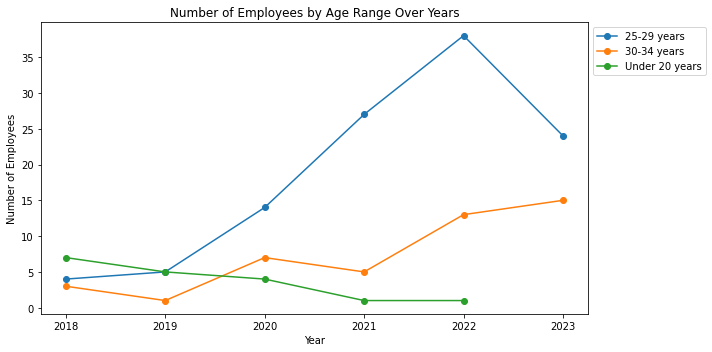

In [44]:
# Lets first filter the age_range labels for specific age ranges
filter_age_ranges = ['Under 20 years', '20-24 years', '25-29 years', '30-34 years']
df_filtered = dataviz_monthly[dataviz_monthly['age_range'].isin(filter_age_ranges)]

# Next, we will group the filtered data by year and age range fields
custom_group = df_filtered.groupby(['Year', 'age_range']).size().unstack()

# Now, we can setup a line chart figure
fig, ax = plt.subplots(figsize=(10, 5))

for age_range in custom_group.columns:
    ax.plot(custom_group.index, custom_group[age_range], label=age_range, marker='o')

# Add labels and title
ax.set_xlabel('Year')
ax.set_ylabel('Number of Employees')
ax.set_title('Number of Employees by Age Range Over Years')

# Move the legend outside to the right
ax.legend(loc='upper left', bbox_to_anchor=(1, 1))

plt.tight_layout()

# Export the plot to an image file
plt.savefig('age_range_line_chart.png', transparent =True)

plt.show()